In [67]:
from yerbamate import env

import os
import pandas as pd

user_aff_path =  os.path.join(env["save"], "hashtags", f"user_hashtag_affiliation.parquet")
label_path = os.path.join(env["save"], "hashtag_propaganda_labeled.csv")
# read CSV file into DataFrame
label_df = pd.read_csv(label_path)
user_aff_df = pd.read_parquet(user_aff_path)

In [35]:
label_df.head()

hashtag           affiliation   label
0      علاءالسالم              ['Shia']  Slogan
1    پایتخت_بصیرت  ['Islamic Republic']  Slogan
2    اقتدار_ایران  ['Islamic Republic']  Slogan
3    غیرتلی_سردار  ['Islamic Republic']  Slogan
4  اربعین_شاهچراغ  ['Islamic Republic']  Slogan

In [36]:
user_aff_df.head()

userId       affiliation  count
0  1930624009              Shia     25
1   408795883              Shia      6
2   143531181  Islamic Republic     32
3  2473674486              Shia     29
4   153841889              Shia     15

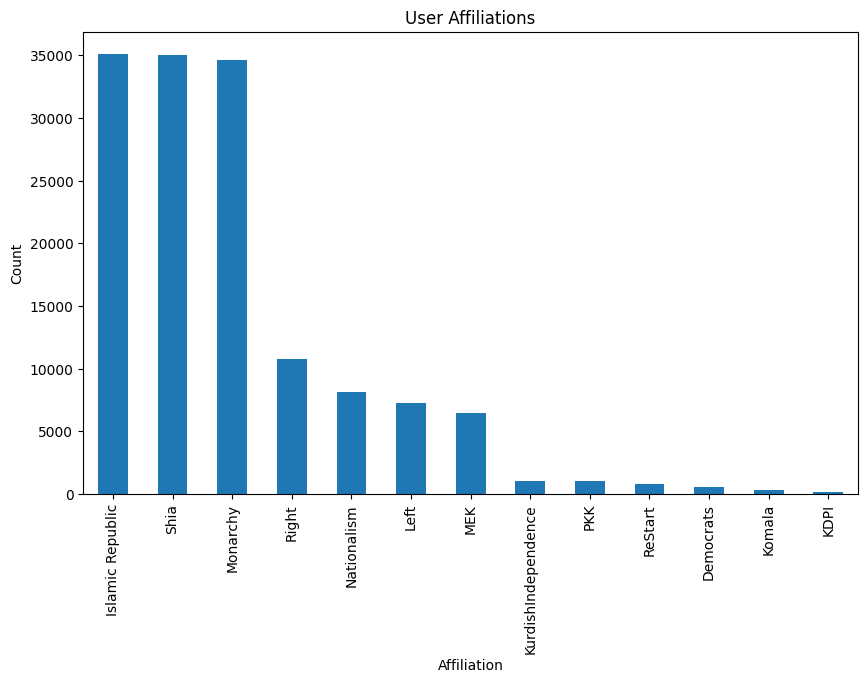

In [37]:
import matplotlib.pyplot as plt

# Get the count of each affiliation
affiliation_counts = user_aff_df['affiliation'].value_counts()

# Generate the plot
plt.figure(figsize=(10,6))
affiliation_counts.plot(kind='bar')
plt.title('User Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Count')
plt.show()


In [10]:
 user_aff_df['affiliation'].unique()

array(['Shia', 'Islamic Republic', 'Left', 'PKK', 'Monarchy', 'MEK',
       'Right', 'Komala', 'ReStart', 'KurdishIndependence', 'Democrats',
       'Nationalism', 'KDPI'], dtype=object)

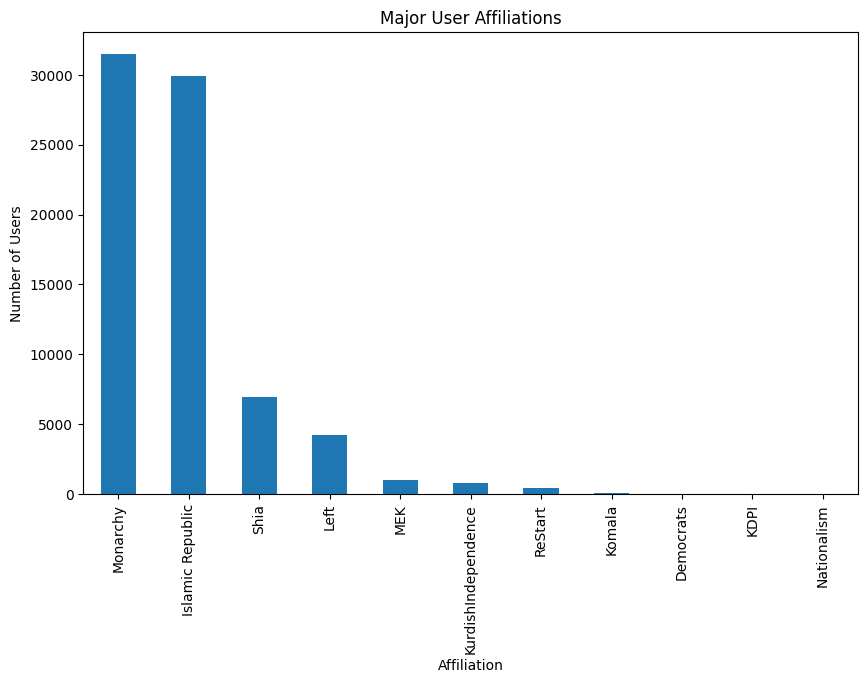

In [30]:
import matplotlib.pyplot as plt

# Group by userId and affiliation, and sum the count
grouped = user_aff_df.groupby(['userId', 'affiliation'])['count'].sum().unstack(fill_value=0)

# Find the major affiliation for each user
grouped['major_affiliation'] = grouped.idxmax(axis=1)

# Count the number of users for each major affiliation
major_affiliation_counts = grouped['major_affiliation'].value_counts()

# Generate the plot
plt.figure(figsize=(10,6))
major_affiliation_counts.plot(kind='bar')
plt.title('Major User Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Number of Users')
plt.show()


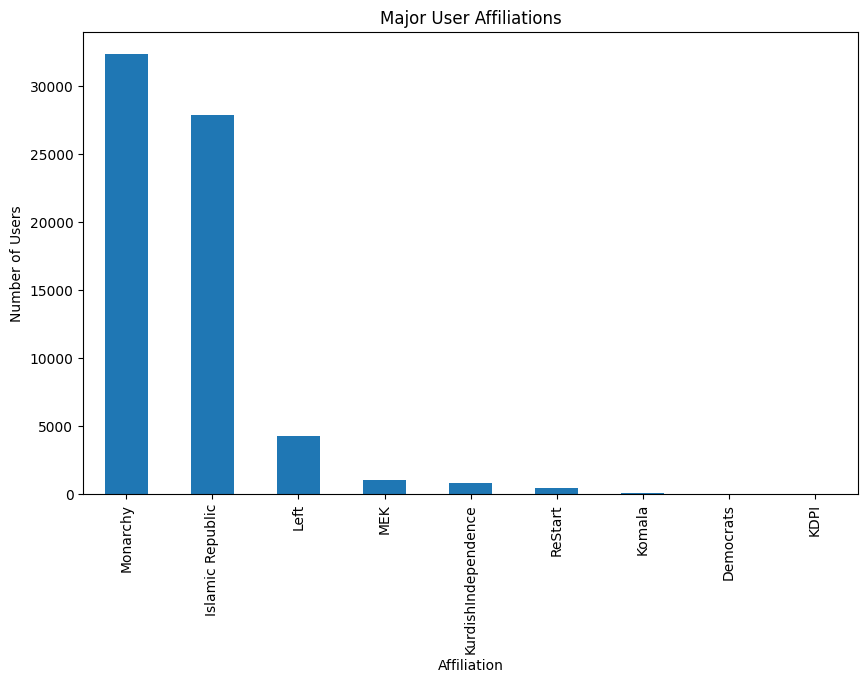

In [69]:
import matplotlib.pyplot as plt

# Define affiliation groupings
affiliation_groupings = {
    'Islamic Republic': ['Islamic Republic'],
    'Monarchy': ['Monarchy', 'Right', 'Nationalism'],
    'MEK': [ 'MEK'],
    'KurdishIndependance': ['KurdishIndependance'],
    'ReStart': ['ReStart'],
    'Left': ['Left'],
}

# drop Shia
user_aff_df = user_aff_df[user_aff_df['affiliation'] != 'Shia']

# Apply groupings and aggregate counts# Apply groupings and aggregate counts
grouped = user_aff_df.copy()
grouped['affiliation'] = grouped['affiliation'].apply(
    lambda x: next((group for group, affiliations in affiliation_groupings.items() if x in affiliations), x)
)
grouped = grouped.groupby(['userId', 'affiliation'])['count'].sum().unstack(fill_value=0)

# Find the major affiliation for each user
grouped['major_affiliation'] = grouped.idxmax(axis=1)

# Count the number of users for each major affiliation
major_affiliation_counts = grouped['major_affiliation'].value_counts()

# Generate the plot
plt.figure(figsize=(10,6))
major_affiliation_counts.plot(kind='bar')
plt.title('Major User Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Number of Users')
plt.show()

In [70]:
user_hashtag_path = os.path.join(env["plots"], "analysis", f"user_hashtag_all.parquet")

user_hashtag_df = pd.read_parquet(user_hashtag_path)

user_hashtag_df.head()

userId             hashtag  count
0  72516079          franceinfo    111
1  72516079           nucleaire      5
2  72516079  VraimentPasDaccord      5
3  72516079               Flers      1
4  72516079          démocratie      7

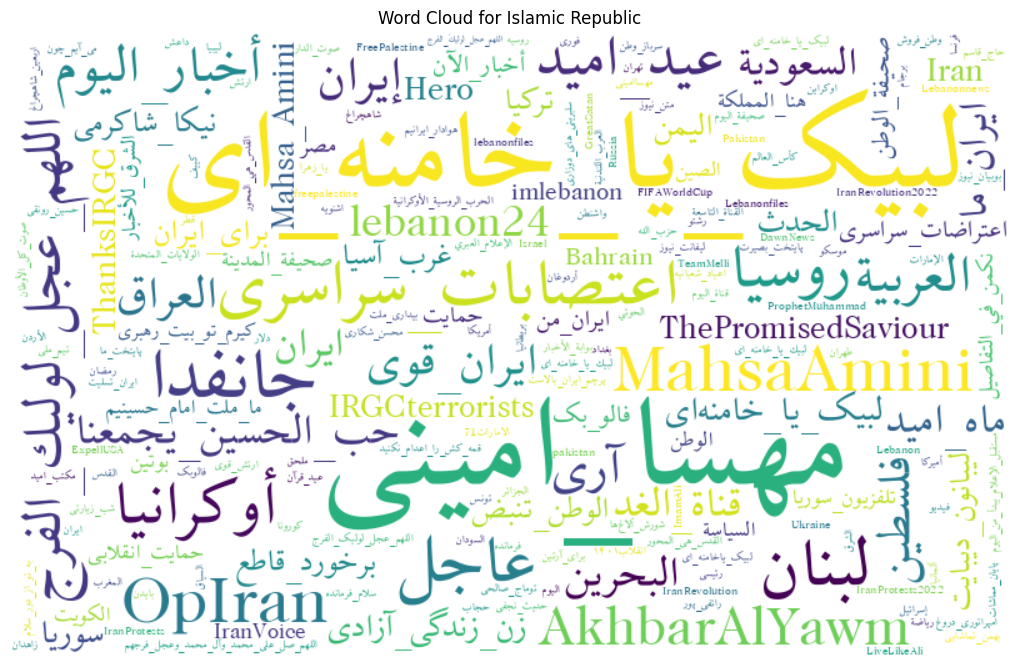

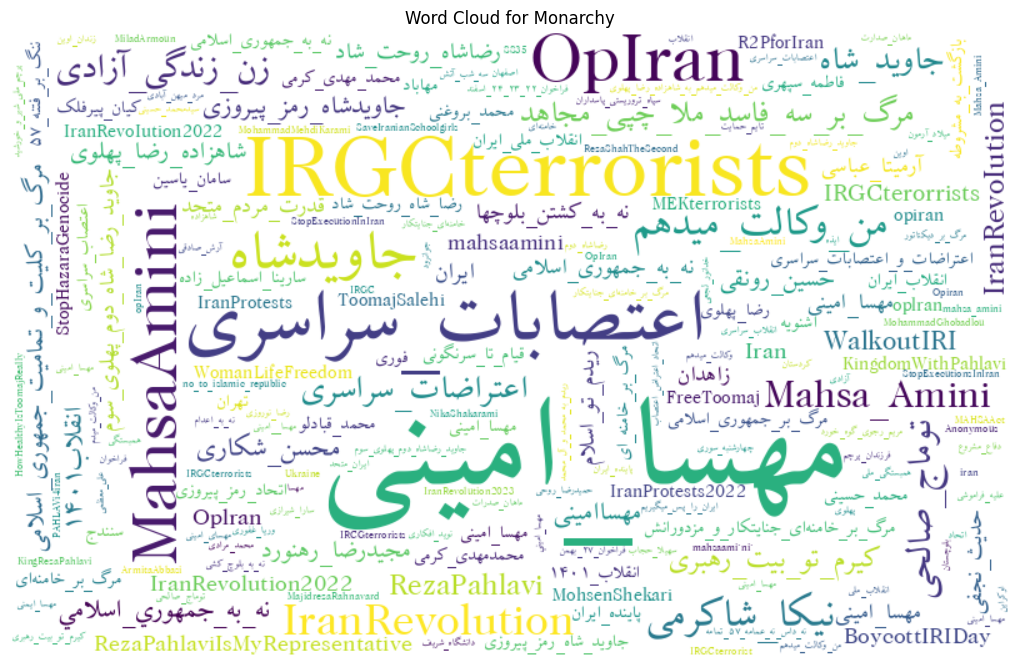

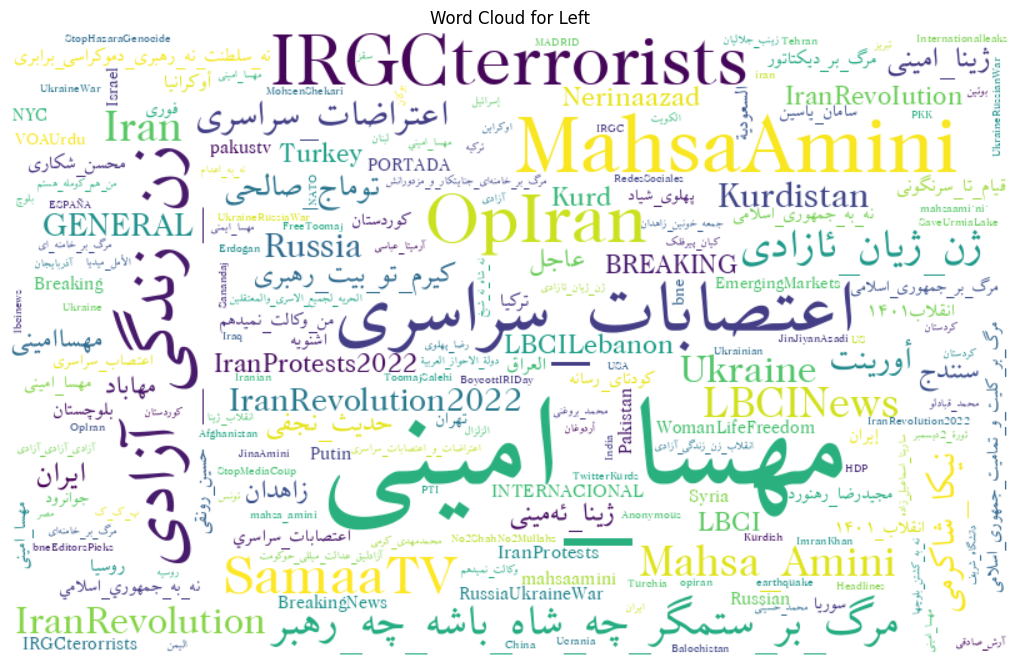

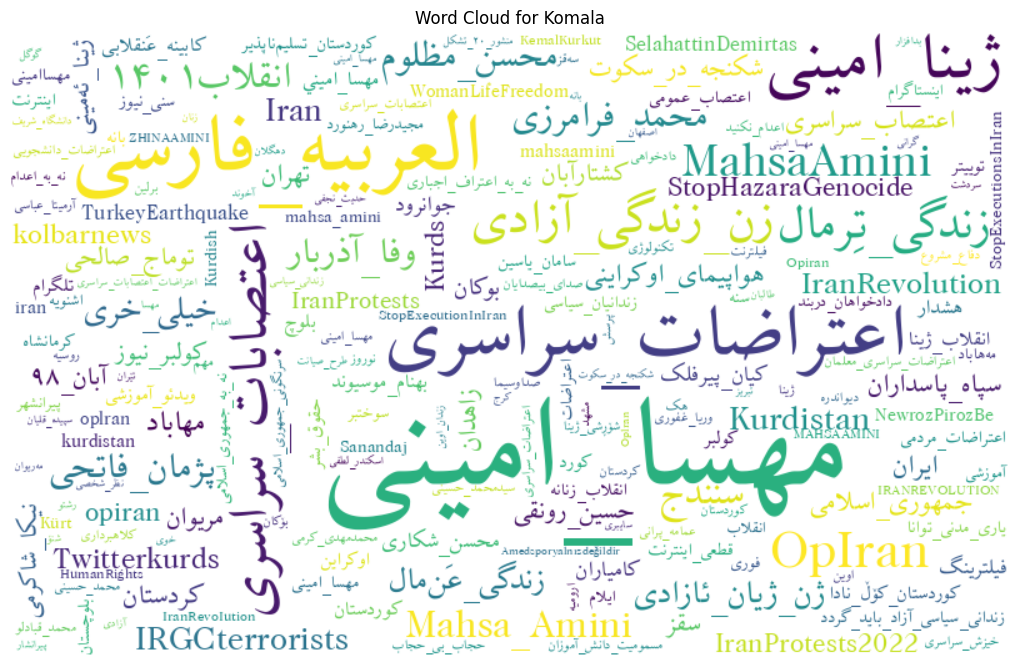

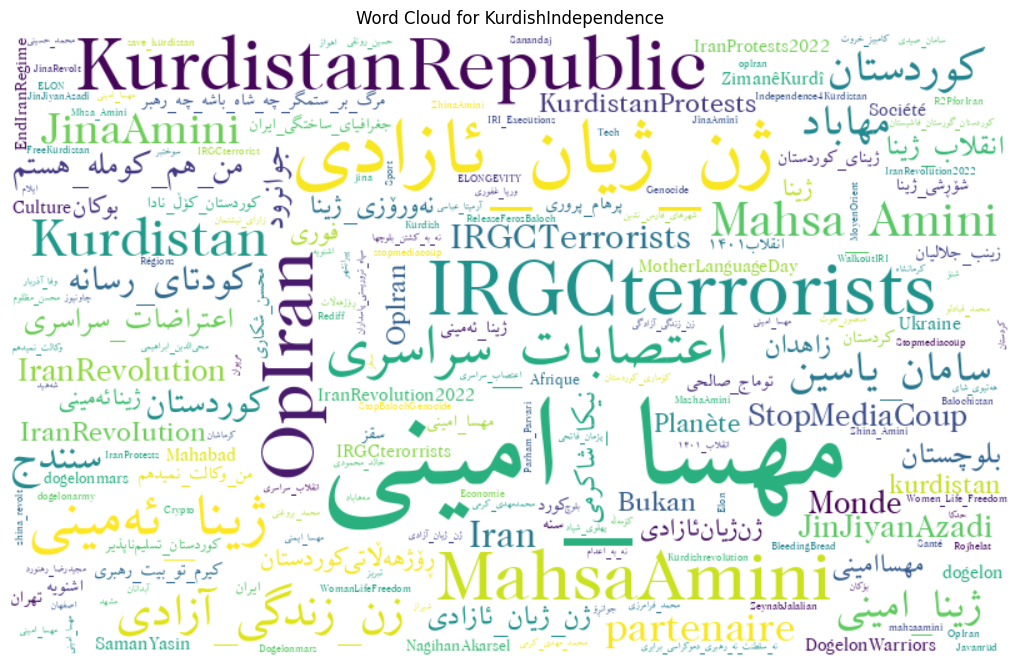

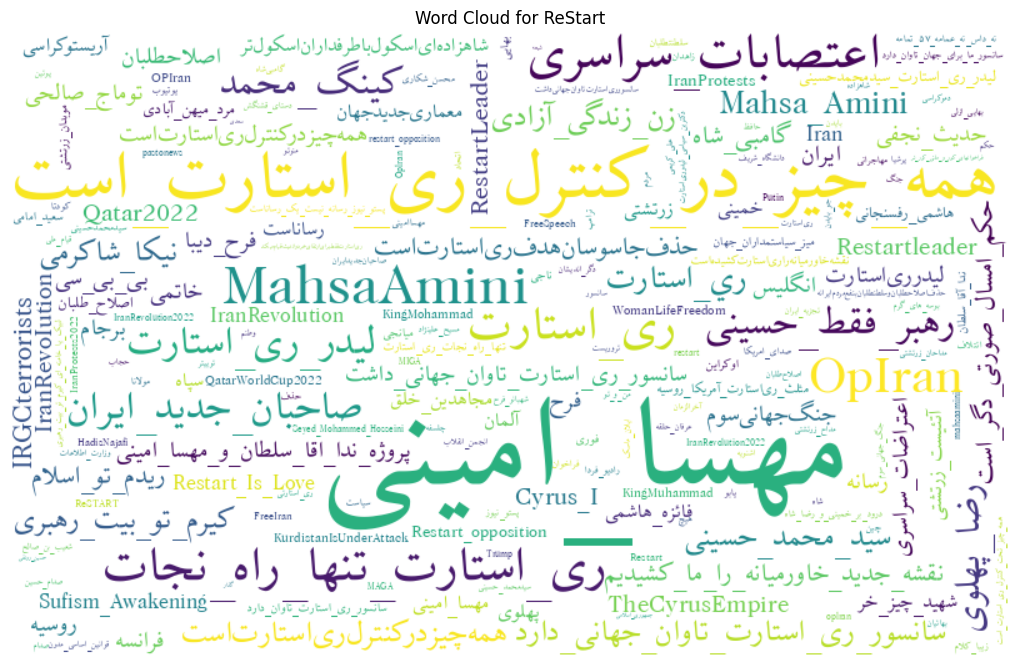

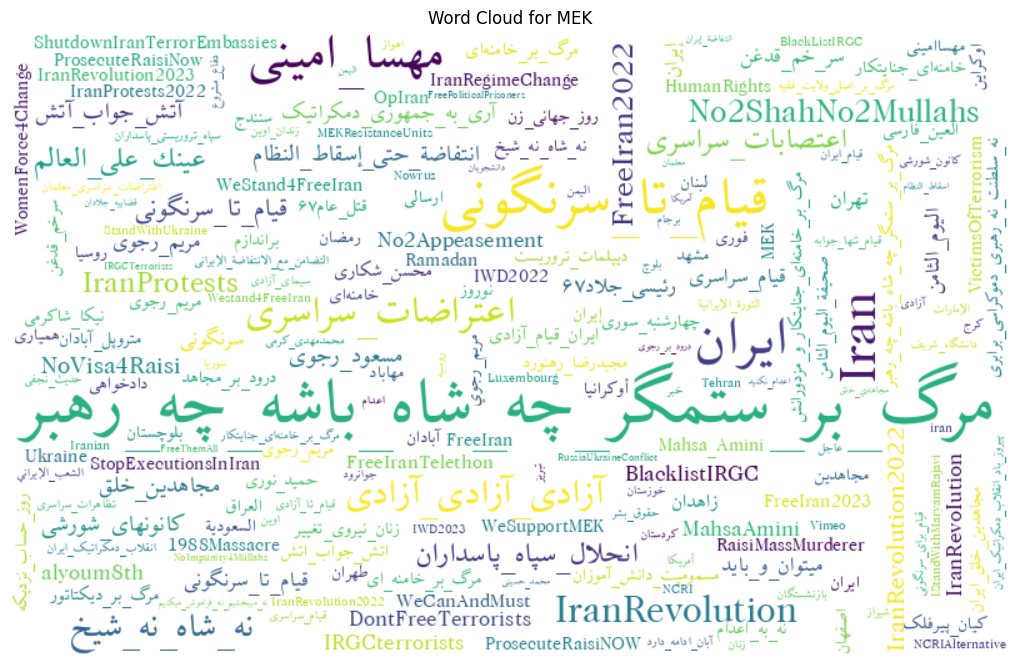

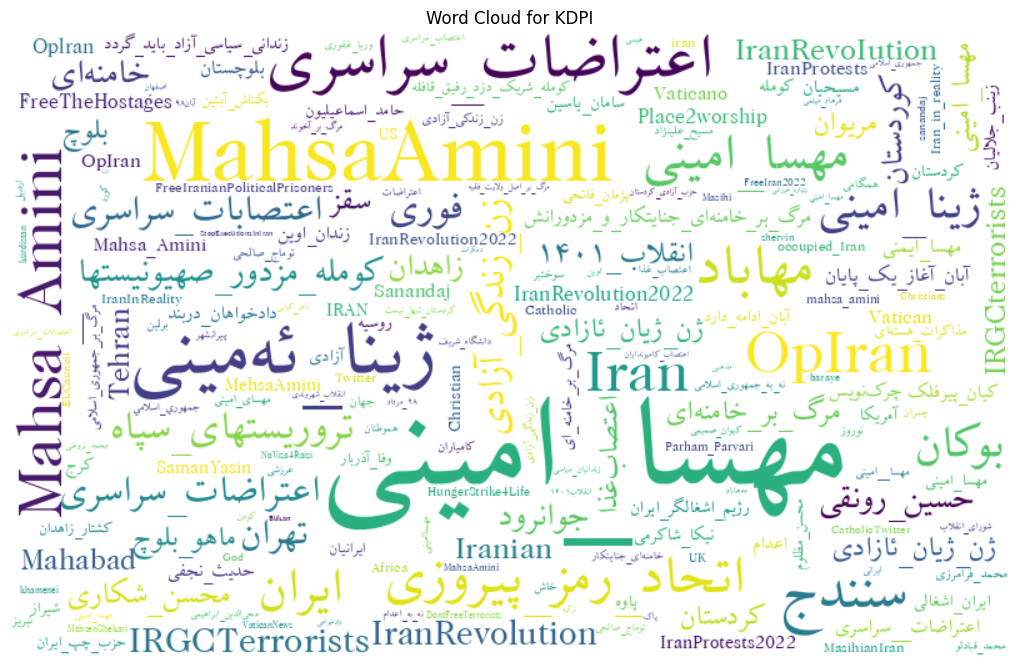

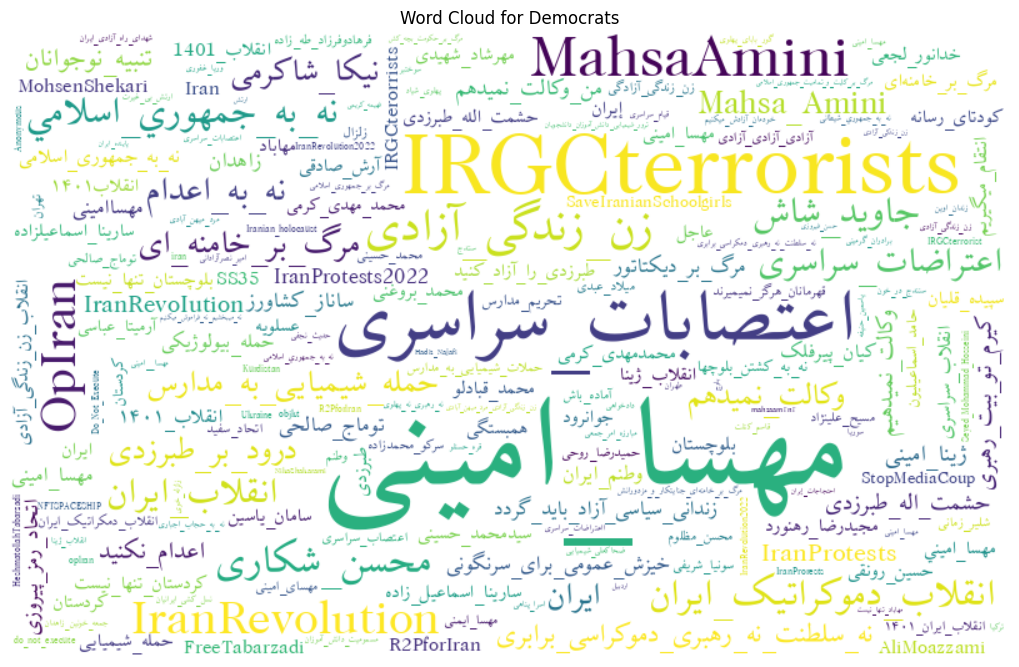

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import os

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

# Join user_hashtag_df with grouped to get the major affiliation for each user
user_hashtag_df = user_hashtag_df.set_index('userId')
grouped = grouped.reset_index()
merged = user_hashtag_df.join(grouped[['userId', 'major_affiliation']].set_index('userId'), how='inner')

# Loop over each major affiliation
for affiliation in merged['major_affiliation'].unique():
    # Filter dataframe to get only the rows with the current affiliation
    df_filtered = merged[merged['major_affiliation'] == affiliation]
    
    # Group by hashtag and count
    freq = df_filtered.groupby("hashtag")['count'].sum()
    freq = freq.sort_values(ascending=False)
    freq = freq[:200]  # Top 200 hashtags

    # Generate and show word cloud
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(freq)

    # Save wordcloud
    save_cloud_path = os.path.join(env["plots"], "analysis", "major_affiliation", f"affiliation_{affiliation}.png")

    if not os.path.exists(os.path.dirname(save_cloud_path)):
        os.makedirs(os.path.dirname(save_cloud_path))

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {get_display(arabic_reshaper.reshape(affiliation))}")
    plt.tight_layout()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    plt.show()
    # plt.savefig(save_cloud_path)


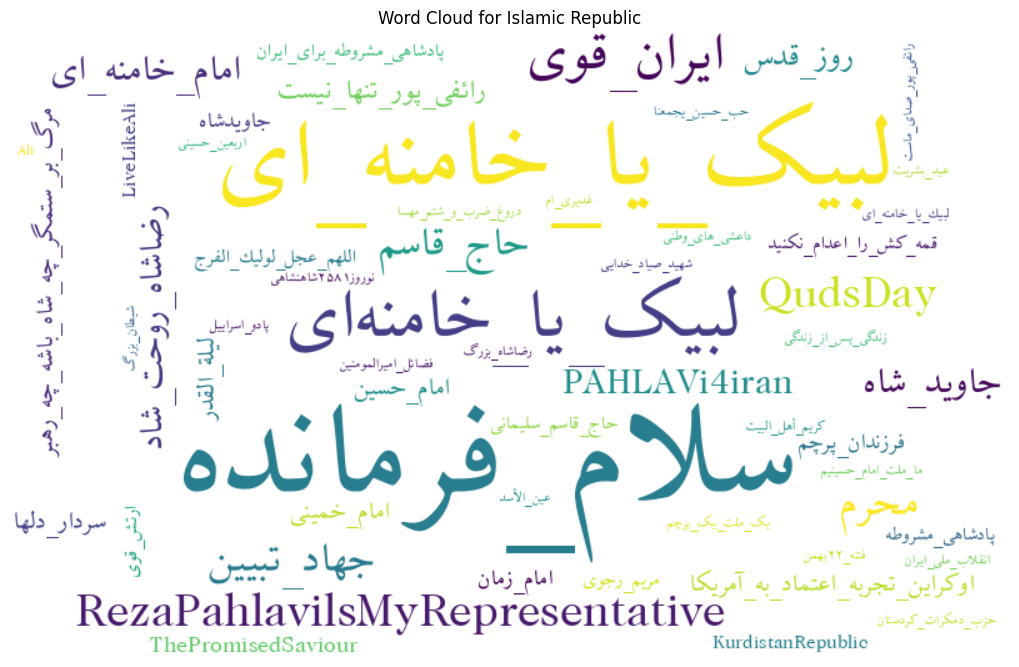

In [73]:
# find top other hashtags for users affiliated with Islamic Republic that use IRGCTerrorists

# Filter dataframe to get only the rows with the current affiliation

affiliation = "Islamic Republic"
hashtag = "IRGCTerrorists"

# pivot to add userId column
merged = merged.reset_index()



df_filtered = merged[(merged['major_affiliation'] == affiliation) & (merged['hashtag'] == hashtag)]
# this will userIds, now lets find other hashtags for these users

df_filtered = merged[merged['userId'].isin(df_filtered['userId'])]

# filter to be in label_df hashtags
df_filtered = df_filtered[df_filtered['hashtag'].isin(label_df['hashtag'])]

# Group by hashtag and count
freq = df_filtered.groupby("hashtag")['count'].sum()


freq = freq.sort_values(ascending=False)
freq = freq[:200]  # Top 200 hashtags

# Generate and show word cloud

wordcloud = WordCloud(
    font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
    width=800,
    height=500,
    random_state=21,
    max_font_size=110,
    background_color="white",
).generate_from_frequencies(freq)

#show word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud for {get_display(arabic_reshaper.reshape(affiliation))}")
plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.show()

In [63]:
import pandas as pd
import ast

# Assuming label_df is your DataFrame
label_df['affiliation'] = label_df['affiliation'].apply(ast.literal_eval)

# exploo


In [5]:
from yerbamate import env
from twitter.data.loader.spark import get_tweets_session, spark
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode, count, from_json, udf, first
from pyspark.sql.types import ArrayType, StringType, DateType

# Load the tweets
columns = ["userId", "hashtags", "date", "user.created"]
parquet_df = get_tweets_session(columns)

# Drop null hashtags
parquet_df = parquet_df.na.drop(subset=["hashtags"])
parquet_df = parquet_df.na.drop(subset=["created"])

# Date filter
time_filter = ((col("date") < "2023-04-17"))
parquet_df = parquet_df.filter(time_filter)

# Load the propaganda labels
label_path = os.path.join(env["save"], "hashtag_propaganda_labeled.csv")
propaganda_labels_df = spark.read.csv(label_path, header=True)

# Convert the 'affiliation' column from a JSON string to an array
array_schema = ArrayType(StringType())
propaganda_labels_df = propaganda_labels_df.withColumn("affiliation", from_json("affiliation", array_schema))
propaganda_labels_df = propaganda_labels_df.select("hashtag", explode(col("affiliation")).alias("affiliation"))

# Explode the hashtags in the parquet df
parquet_df = parquet_df.select("userId", "date", explode(col("hashtags")).alias("hashtag"), "created")

# Join the dataframes
joined_df = parquet_df.join(propaganda_labels_df, "hashtag", "inner")

# Affiliation grouping
affiliation_groupings = {
    'Islamic Republic': ['Islamic Republic'],
    'Monarchy': ['Monarchy', 'Right', 'Nationalism'],
    'MEK': ['MEK', 'Left'],
    'KurdishIndependance': ['KurdishIndependance'],
    'ReStart': ['ReStart'],
    'Left': ['Left'],
}

def hashtag_to_affiliation(hashtag):
    for key, values in affiliation_groupings.items():
        if hashtag in values:
            return key
    return None

hashtag_to_affiliation_udf = udf(hashtag_to_affiliation, StringType())




In [8]:
joined_df = joined_df.withColumn('affiliation_group', hashtag_to_affiliation_udf(joined_df['hashtag']))

# Analyze the affiliation over time
# affiliation_over_time = joined_df.groupBy('userId', 'affiliation_group', 'date', 'user.createdAt').agg(count('hashtag').alias('count'), first("date").alias("first_tweet"))
# Analyze the affiliation over time
affiliation_over_time = joined_df.groupBy('affiliation_group', 'date').agg(count('hashtag').alias('count'))

# Save the results
#affiliation_over_time.write.mode("overwrite").parquet(os.path.join(env["save"], "hashtags", f"user_hashtag_affiliation.parquet"))

# Visualize affiliation changes over time
pdf = affiliation_over_time.toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])
pdf.set_index('date', inplace=True)

pdf.groupby('affiliation_group')['count'].plot(legend=True)

plt.show()

/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/tmp/ipykernel_4331/1725155691.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pdf.groupby('affiliation_group')['count'].plot(legend=True)


In [12]:
pdf = affiliation_over_time.toPandas()

/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [14]:
pdf.columns

Index(['affiliation_group', 'date', 'count'], dtype='object')

In [11]:
pdf[ (pdf['affiliation_group'] == 'Islamic Republic') & (pdf['date'] > '2020-01-01')]['count'].plot(legend=True)

KeyError: 'date'

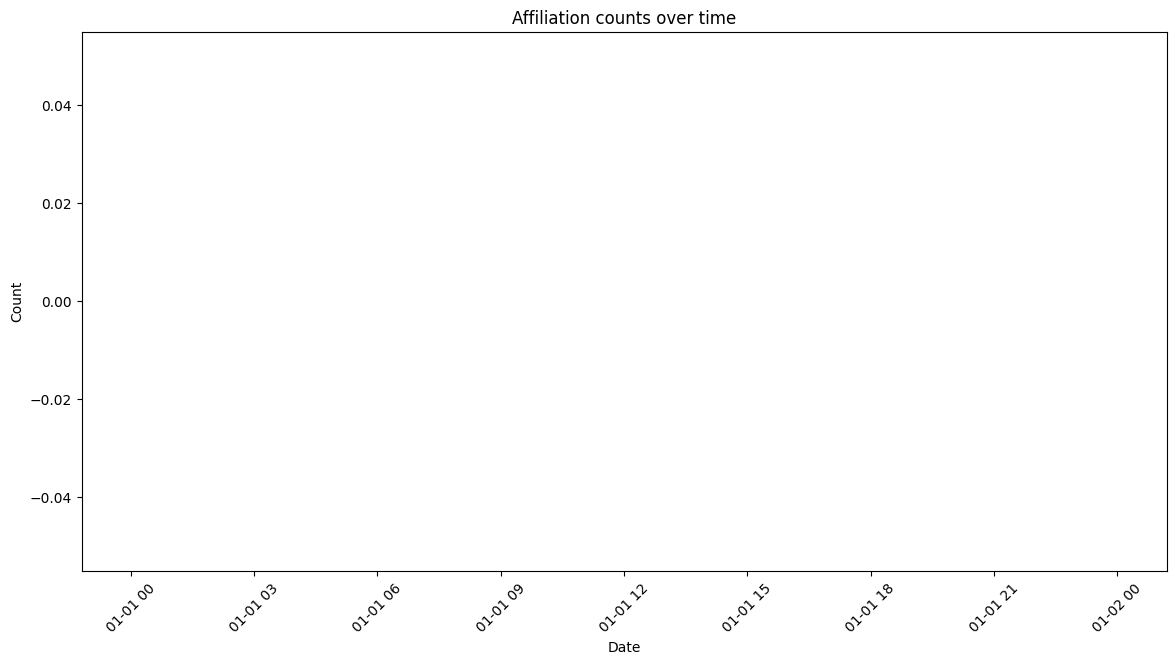

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size
plt.figure(figsize=(14,7))

# Create a line plot for each affiliation group
sns.lineplot(data=pdf, x="date", y="count", hue="affiliation_group")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title and labels
plt.title('Affiliation counts over time')
plt.xlabel('Date')
plt.ylabel('Count')

# Display the plot
plt.show()


In [13]:
pdf.columns

Index(['affiliation_group', 'date', 'count'], dtype='object')

In [2]:
from yerbamate import env
from twitter.data.loader.spark import get_tweets_session, spark
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode, count, from_json, udf, first
from pyspark.sql.types import ArrayType, StringType, DateType

# Load the tweets
columns = ["userId", "hashtags", "date", "user.created"]
parquet_df = get_tweets_session(columns)

# Drop null hashtags and user.created
parquet_df = parquet_df.na.drop(subset=["hashtags", "created"])

# Date filter
time_filter = ((col("date") < "2023-04-17"))
parquet_df = parquet_df.filter(time_filter)

# Load the propaganda labels
label_path = os.path.join(env["save"], "hashtag_propaganda_labeled.csv")
propaganda_labels_df = spark.read.csv(label_path, header=True)

# Convert the 'affiliation' column from a JSON string to an array
array_schema = ArrayType(StringType())
propaganda_labels_df = propaganda_labels_df.withColumn("affiliation", from_json("affiliation", array_schema))
propaganda_labels_df = propaganda_labels_df.select("hashtag", explode(col("affiliation")).alias("affiliation"))

# Explode the hashtags in the parquet df
parquet_df = parquet_df.select("userId", "date", explode(col("hashtags")).alias("hashtag"), "created")

# Join the dataframes
joined_df = parquet_df.join(propaganda_labels_df, "hashtag", "inner")

# Affiliation grouping
affiliation_groupings = {
    'Islamic Republic': ['Islamic Republic'],
    'Monarchy': ['Monarchy', 'Right', 'Nationalism'],
    'MEK': ['MEK', 'Left'],
    'KurdishIndependance': ['KurdishIndependance'],
    'ReStart': ['ReStart'],
    'Left': ['Left'],
}

def hashtag_to_affiliation(hashtag):
    for key, values in affiliation_groupings.items():
        if hashtag in values:
            return key
    return None

hashtag_to_affiliation_udf = udf(hashtag_to_affiliation, StringType())

# Use the UDF to add the affiliation_group column
joined_df = joined_df.withColumn('affiliation_group', hashtag_to_affiliation_udf(col('hashtag')))

# Calculate usage count
usage_count = joined_df.groupBy('userId', 'date', 'affiliation_group').agg(count('hashtag').alias('count'), first('created').alias('user_created'))

# Convert the DataFrame to Pandas
pdf = usage_count.toPandas()

23/07/07 16:57:10 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 2122317824 bytes). This may impact query planning performance.
/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [4]:
pdf_c = pdf.copy()

In [8]:
pdf.iloc[0]

userId                          47759926
affiliation_group                   None
count                                  2
user_created         2009-06-17 00:40:16
Name: 2009-09-13 22:56:22, dtype: object

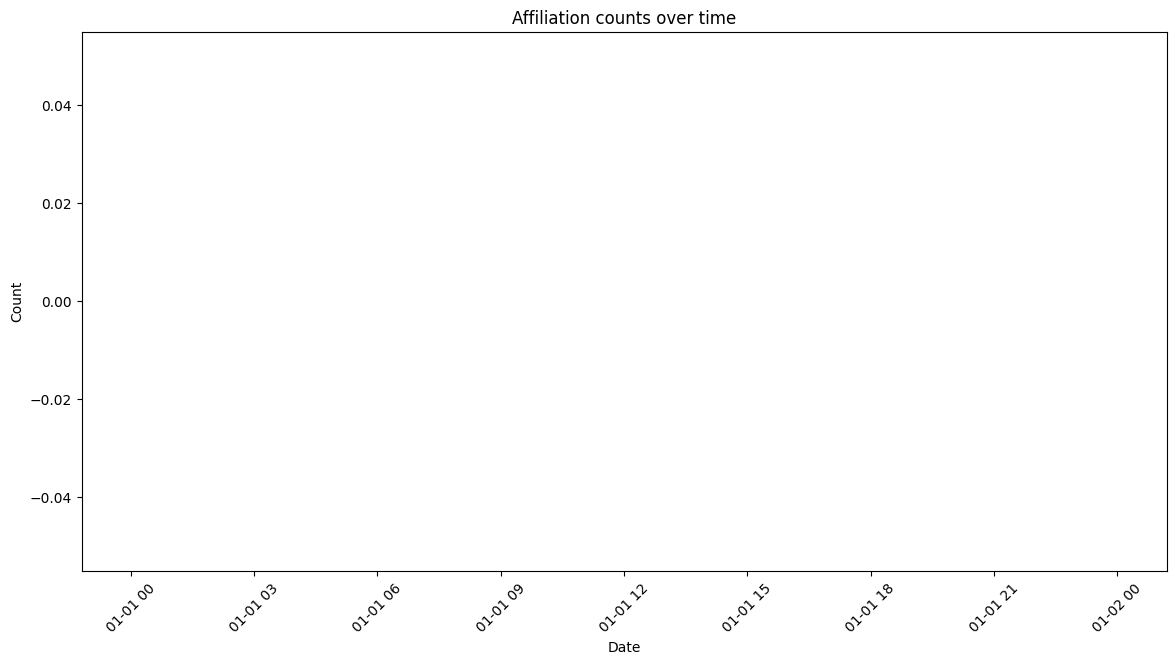

In [7]:
# Sort the DataFrame by date
pdf = pdf.sort_values('date')
import seaborn as sns

# Set the date as the index
#pdf.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(14,7))
sns.lineplot(data=pdf, x="date", y="count", hue="affiliation_group")
plt.xticks(rotation=45)
plt.title('Affiliation counts over time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


In [22]:
from yerbamate import env
from twitter.data.loader.spark import get_tweets_session, spark
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode, count, from_json, udf, first
from pyspark.sql.types import ArrayType, StringType, DateType

# Load the tweets
columns = ["userId", "hashtags", "date", "user.created"]
parquet_df = get_tweets_session(columns)

# Drop null hashtags
parquet_df = parquet_df.na.drop(subset=["hashtags"])
parquet_df = parquet_df.na.drop(subset=["created"])

# Date filter
time_filter = ((col("date") < "2023-04-17"))
parquet_df = parquet_df.filter(time_filter)

# Load the propaganda labels
label_path = os.path.join(env["save"], "hashtag_propaganda_labeled.csv")
propaganda_labels_df = spark.read.csv(label_path, header=True)

# Convert the 'affiliation' column from a JSON string to an array
array_schema = ArrayType(StringType())
propaganda_labels_df = propaganda_labels_df.withColumn("affiliation", from_json("affiliation", array_schema))
propaganda_labels_df = propaganda_labels_df.select("hashtag", explode(col("affiliation")).alias("affiliation"))

# Explode the hashtags in the parquet df
parquet_df = parquet_df.select("userId", "date", explode(col("hashtags")).alias("hashtag"), "created")

# Join the dataframes
joined_df = parquet_df.join(propaganda_labels_df, "hashtag", "inner")

# Affiliation grouping
affiliation_groupings = {
    'Islamic Republic': ['Islamic Republic'],
    'Monarchy': ['Monarchy', 'Right', 'Nationalism'],
    'MEK': ['MEK', 'Left'],
    'KurdishIndependance': ['KurdishIndependance'],
    'ReStart': ['ReStart'],
    'Left': ['Left'],
    'Democrats': ['Democrats'],
}

# Function to map affiliation to affiliation group
def affiliation_to_group(affiliation):
    for key, values in affiliation_groupings.items():
        if affiliation in values:
            return key
    return None

# UDF for affiliation to group
affiliation_to_group_udf = udf(affiliation_to_group, StringType())

# Create new column for affiliation group
joined_df = joined_df.withColumn("affiliation_group", affiliation_to_group_udf(joined_df["affiliation"]))

# Compute user's first tweet and account creation date
user_first_info = joined_df.groupBy('userId').agg(first('date').alias('first_tweet'), first('created').alias('created'))

# Compute count for each user, affiliation group, and date
usage_count = joined_df.groupBy('userId', 'affiliation_group', 'date').agg(count('hashtag').alias('count'))

# Join the dataframes
final_df = usage_count.join(user_first_info, 'userId', 'inner')

In [23]:
df = final_df.toPandas()

/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/al/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [27]:
cdf = df.copy()

In [25]:
len(cdf['userId'].unique())

73600

In [28]:
df.head()

userId affiliation_group                date  count  \
0  1208408725465321474  Islamic Republic 2022-08-28 13:26:40      1   
1  1208408725465321474              None 2020-08-07 14:04:54      1   
2  1257079997958811649  Islamic Republic 2020-07-30 14:25:42      1   
3  1385392925207629827              None 2022-03-25 06:37:25      1   
4  1385392925207629827              None 2022-01-30 09:20:24      1   

          first_tweet             created  
0 2023-03-30 13:37:01 2019-12-21 16:28:35  
1 2023-03-30 13:37:01 2019-12-21 16:28:35  
2 2021-05-05 22:52:50 2020-05-04 00:50:36  
3 2023-03-21 16:16:40 2021-04-23 02:40:11  
4 2023-03-21 16:16:40 2021-04-23 02:40:11

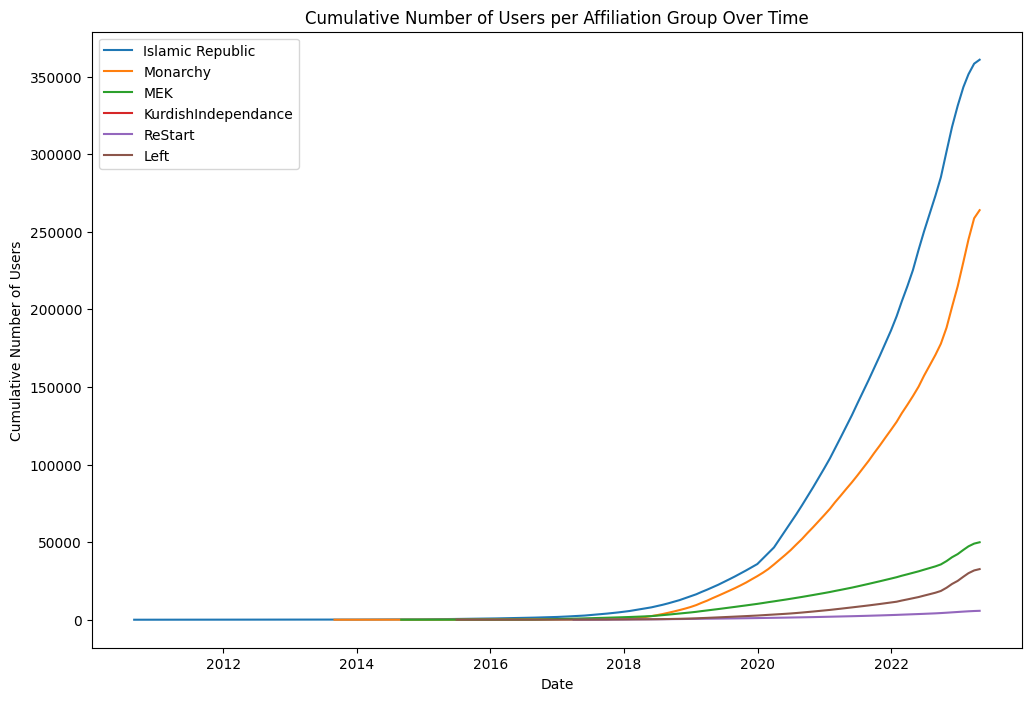

In [47]:
# Convert date to datetime index
from pandas import CategoricalDtype

df = cdf.copy()


# Convert date to datetime index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Group by 'userId', 'affiliation_group', and resample by month
grouped_df = df.groupby(['userId', 'affiliation_group']).resample('M').size().reset_index(name='counts')

# Group by 'date' and 'affiliation_group' and count unique 'userId'
grouped_data = grouped_df.groupby(['date', 'affiliation_group'])['userId'].nunique().reset_index(name='counts')

# Calculate cumulative sum of counts per group
grouped_data['cumulative_counts'] = grouped_data.groupby('affiliation_group')['counts'].cumsum()

# Define order for the affiliation group
affiliation_order = [ 'Islamic Republic', 'Monarchy', 'MEK', 'KurdishIndependance', 'ReStart', 'Left']
cat_type = CategoricalDtype(categories=affiliation_order, ordered=True)
grouped_data['affiliation_group'] = grouped_data['affiliation_group'].astype(cat_type)

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_data, x='date', y='cumulative_counts', hue='affiliation_group')
plt.title("Cumulative Number of Users per Affiliation Group Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Number of Users")
plt.legend(loc='upper left')
plt.show()

In [53]:
import plotly.graph_objects as go

# Data preparation: you'll need to prepare 'source', 'target', and 'value' lists
# 'source' and 'target' are affiliation group indices, 'value' is the count of users who switched from one group to another
source = [0, 0, 0, 0, 0] # Islamic Republic is the source of both flows
target = [1, 2] # The first flow ends at Monarchy, the second flow ends at MEK
value = [10, 5] # 10 users transitioned in the first flow, 5 users transitioned in the second


# Create the Sankey diagram object
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=["Islamic Republic", "Monarchy", "MEK", "KurdishIndependance", "ReStart", "Left"],  # Labels for the affiliation groups
      color="blue"
    ),
    link=dict(
      source=source, 
      target=target,
      value=value
    ))])

fig.update_layout(title_text="User Flow Between Affiliation Groups Chane from Islamic Republic", font_size=10)
fig.show()

In [54]:
# Shift the 'affiliation_group' column within each user group to generate a new column 'next_affiliation'
df['next_affiliation'] = df.groupby('userId')['affiliation_group'].shift(-1)

# Drop rows where 'next_affiliation' is NaN (these are the last rows for each user)
df = df.dropna(subset=['next_affiliation'])

# For each user, generate pairs of consecutive affiliations and count the number of occurrences of each pair
transitions = df.groupby('userId')[['affiliation_group', 'next_affiliation']].apply(lambda x: list(zip(x['affiliation_group'], x['next_affiliation']))).explode().value_counts()

# Convert the result to a DataFrame
transitions_df = transitions.reset_index()
transitions_df.columns = ['transition', 'count']

# Split the 'transition' tuple into two columns
transitions_df[['source', 'target']] = pd.DataFrame(transitions_df['transition'].tolist(), index=transitions_df.index)

# Drop the 'transition' column
transitions_df = transitions_df.drop(columns='transition')

print(transitions_df)

      count            source            target
0   2323658          Monarchy          Monarchy
1    846332  Islamic Republic  Islamic Republic
2    626988              None  Islamic Republic
3    361639               MEK               MEK
4    239991              Left               MEK
5    239532               MEK              Left
6    201878              Left              Left
7     50652           ReStart           ReStart
8      7418              None          Monarchy
9      5365  Islamic Republic          Monarchy
10     5270          Monarchy  Islamic Republic
11     4771               MEK          Monarchy
12     4676          Monarchy               MEK
13     3112              None               MEK
14     2685              None              Left
15     2667          Monarchy              Left
16     2611              Left          Monarchy
17     1722               MEK         Democrats
18     1703         Democrats               MEK
19     1101              Left         De

In [55]:
df.head()

userId affiliation_group                date  count  \
1    1208408725465321474              None 2020-08-07 14:04:54      1   
48   1385392925207629827              None 2021-09-22 20:55:40      1   
59   1385392925207629827              None 2021-11-24 04:10:07      1   
107  1385392925207629827              None 2021-08-29 10:13:19      1   
139  1338088523245752321              None 2022-11-18 12:45:30      1   

            first_tweet             created  next_affiliation  
1   2023-03-30 13:37:01 2019-12-21 16:28:35          Monarchy  
48  2023-03-21 16:16:40 2021-04-23 02:40:11  Islamic Republic  
59  2023-03-21 16:16:40 2021-04-23 02:40:11  Islamic Republic  
107 2023-03-21 16:16:40 2021-04-23 02:40:11  Islamic Republic  
139 2023-04-10 02:47:39 2020-12-13 12:49:09  Islamic Republic

In [56]:
df = cdf.copy()
df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df['date'].dt.to_period('M')

# Group by 'userId', 'month_year', and 'affiliation_group', and count the number of tweets
grouped_df = df.groupby(['userId', 'month_year', 'affiliation_group']).size().reset_index(name='counts')

# Identify the major affiliation_group for each user in each month_year
major_affiliation = grouped_df.loc[grouped_df.groupby(['userId', 'month_year'])['counts'].idxmax()]

# This DataFrame now contains one row for each user and month_year, with the affiliation_group for which the user had the most tweets in that month_year
print(major_affiliation)

                     userId month_year affiliation_group  counts
0                      7552    2020-01  Islamic Republic       1
1                      7552    2020-02  Islamic Republic       1
2                      7552    2022-05  Islamic Republic       1
3                      7552    2022-06  Islamic Republic       1
4                    670643    2019-08  Islamic Republic       1
...                     ...        ...               ...     ...
325017  1643748247196909568    2023-04          Monarchy       6
325018  1644240405012127744    2023-04          Monarchy       1
325019  1645092600473595905    2023-04          Monarchy       4
325020  1645357369298153475    2023-04          Monarchy      39
325021  1645760566550581248    2023-04          Monarchy       5

[302269 rows x 4 columns]


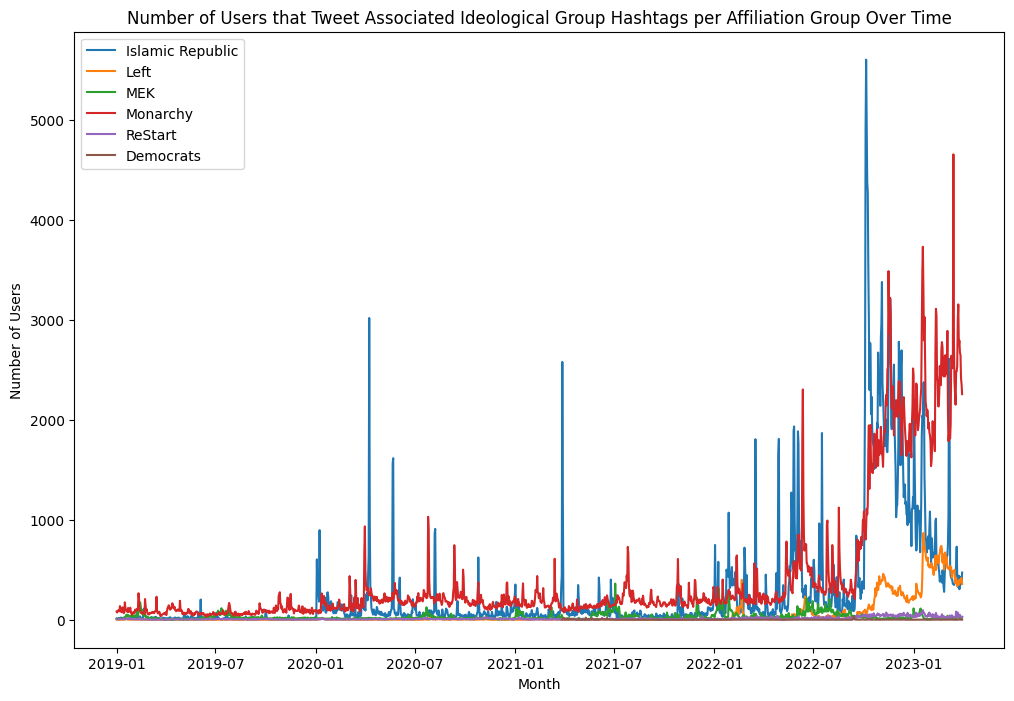

In [76]:
# Group by 'month_year' and 'affiliation_group', and count unique 'userId'
df = cdf.copy()
df['date'] = pd.to_datetime(df['date'])

# filter < 2023-04-01
df = df[df['date'] < '2023-04-01']

# show after 2016-01-01
df = df[df['date'] > '2019-01-01']

df['month_year'] = df['date'].dt.to_period('D')

# Group by 'userId', 'month_year', and 'affiliation_group', and count the number of tweets
grouped_df = df.groupby(['userId', 'month_year', 'affiliation_group']).size().reset_index(name='counts')

# Identify the major affiliation_group for each user in each month_year
major_affiliation = grouped_df.loc[grouped_df.groupby(['userId', 'month_year'])['counts'].idxmax()]

# This DataFrame now contains one row for each user and month_year, with the affiliation_group for which the user had the most tweets in that month_year
grouped_data = major_affiliation.groupby(['month_year', 'affiliation_group'])['userId'].nunique().reset_index(name='counts')

# Define order for the affiliation group
affiliation_order = ['Islamic Republic', 'Monarchy', 'MEK', 'KurdishIndependance', 'ReStart', 'Left']
cat_type = pd.CategoricalDtype(categories=affiliation_order, ordered=True)
# Convert 'month_year' back to datetime
grouped_data['month_year'] = grouped_data['month_year'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_data, x='month_year', y='counts', hue='affiliation_group')
plt.title("Number of Users that Tweet Associated Ideological Group Hashtags per Affiliation Group Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Users")
plt.legend(loc='upper left')
plt.show()



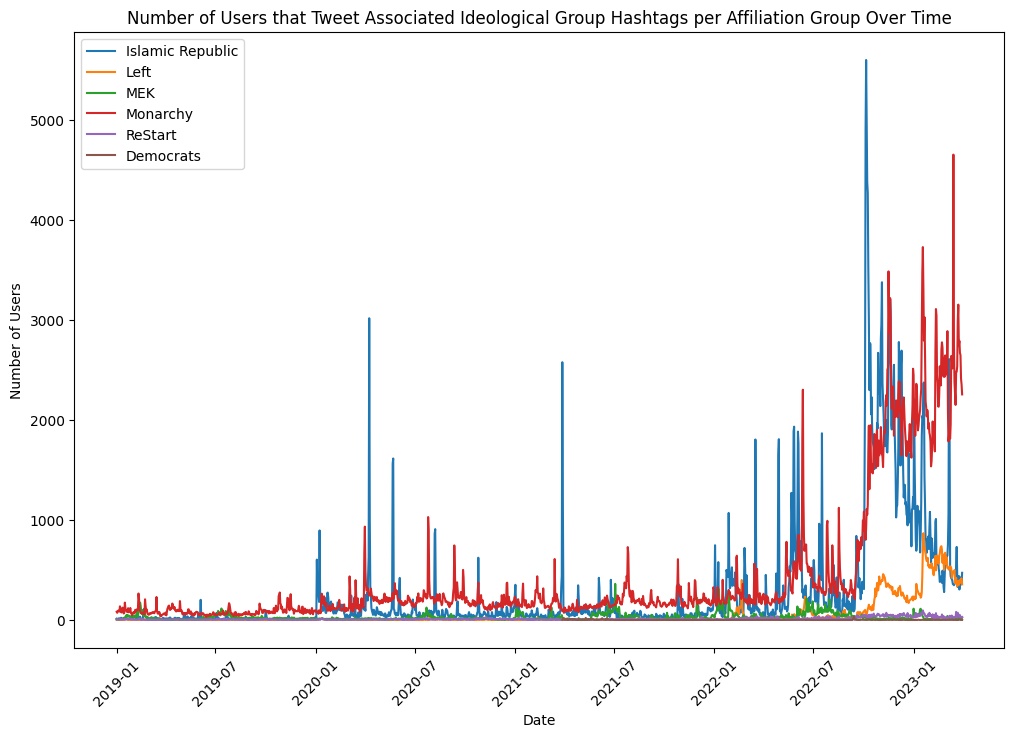

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'month_year' and 'affiliation_group', and count unique 'userId'
df = cdf.copy()
df['date'] = pd.to_datetime(df['date'])

# Filter < 2023-04-01 and > 2019-01-01
df = df[(df['date'] < '2023-04-01') & (df['date'] > '2019-01-01')]

df['month_year'] = df['date'].dt.to_period('D')

# Group by 'userId', 'month_year', and 'affiliation_group', and count the number of tweets
grouped_df = df.groupby(['userId', 'month_year', 'affiliation_group']).size().reset_index(name='counts')

# Identify the major affiliation_group for each user in each month_year
major_affiliation = grouped_df.loc[grouped_df.groupby(['userId', 'month_year'])['counts'].idxmax()]

# This DataFrame now contains one row for each user and month_year, with the affiliation_group for which the user had the most tweets in that month_year
grouped_data = major_affiliation.groupby(['month_year', 'affiliation_group'])['userId'].nunique().reset_index(name='counts')

# Define order for the affiliation group
affiliation_order = ['Islamic Republic', 'Monarchy', 'MEK', 'KurdishIndependance', 'ReStart', 'Left']
cat_type = pd.CategoricalDtype(categories=affiliation_order, ordered=True)

# Convert 'month_year' back to datetime with full day
grouped_data['month_year'] = grouped_data['month_year'].d

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_data, x='month_year', y='counts', hue='affiliation_group')
plt.title("Number of Users that Tweet Associated Ideological Group Hashtags per Affiliation Group Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.legend(loc='upper left')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'month_year' and 'affiliation_group', and count unique 'userId'
df = cdf.copy()
df['date'] = pd.to_datetime(df['date'])

# Filter < 2023-04-01 and > 2019-01-01
df = df[(df['date'] < '2023-04-01') & (df['date'] > '2019-01-01')]

df['month_year'] = df['date'].dt.to_period('D')

# Group by 'userId', 'month_year', and 'affiliation_group', and count the number of tweets
grouped_df = df.groupby(['userId', 'month_year', 'affiliation_group']).size().reset_index(name='counts')

# Identify the major affiliation_group for each user in each month_year
major_affiliation = grouped_df.loc[grouped_df.groupby(['userId', 'month_year'])['counts'].idxmax()]

# This DataFrame now contains one row for each user and month_year, with the affiliation_group for which the user had the most tweets in that month_year
grouped_data = major_affiliation.groupby(['month_year', 'affiliation_group'])['userId'].nunique().reset_index(name='counts')

# Define order for the affiliation group
affiliation_order = ['Islamic Republic', 'Monarchy', 'MEK', 'KurdishIndependance', 'ReStart', 'Left']
cat_type = pd.CategoricalDtype(categories=affiliation_order, ordered=True)

# Convert 'month_year' back to datetime with full day
grouped_data['month_year'] = pd.to_datetime(grouped_data['month_year'])

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_data, x='month_year', y='counts', hue='affiliation_group')
plt.title("Number of Users that Tweet Associated Ideological Group Hashtags per Affiliation Group Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.legend(loc='upper left')

# Format x-axis labels as 'year-month-day'
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_data['month_year'].dt.strftime('%Y-%m-%d')))

plt.tight_layout()
plt.show()


In [63]:
grouped_data.head()

month_year affiliation_group  counts
0 2010-08-01  Islamic Republic       1
1 2010-09-01  Islamic Republic       1
2 2011-04-01  Islamic Republic       1
3 2011-05-01  Islamic Republic       1
4 2011-07-01  Islamic Republic       1

Number of users who transitioned from 'Islamic Republic' to another group: 2708


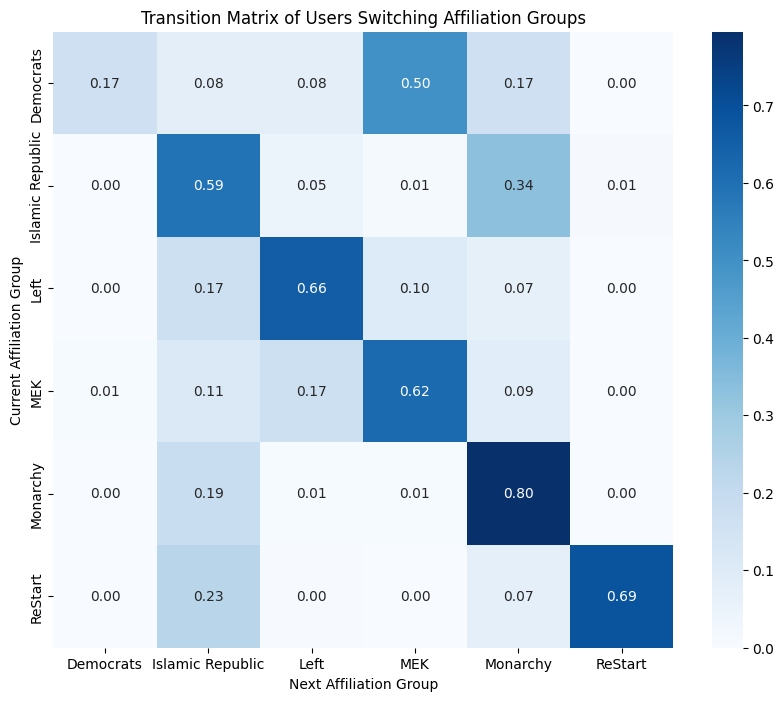

In [67]:


# Step 1: Create a list of users who have ever been affiliated with 'Islamic Republic'
islamic_republic_users = major_affiliation[major_affiliation['affiliation_group'] == 'Islamic Republic']['userId'].unique()

# Step 2: Find users in this list who also appear under different affiliation groups
other_affiliation_users = major_affiliation[
    major_affiliation['userId'].isin(islamic_republic_users) & 
    (major_affiliation['affiliation_group'] != 'Islamic Republic')
]['userId'].unique()

print(f"Number of users who transitioned from 'Islamic Republic' to another group: {len(other_affiliation_users)}")


# Subset of the data with only users who switched from 'Islamic Republic'
transition_data = major_affiliation[major_affiliation['userId'].isin(other_affiliation_users)].sort_values(['userId', 'month_year'])

# Create a new column that holds the affiliation group of the next month
transition_data['next_group'] = transition_data.groupby('userId')['affiliation_group'].shift(-1)

# Create the transition matrix
transition_matrix = pd.crosstab(transition_data['affiliation_group'], transition_data['next_group'], normalize='index')

# Plot the transition matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, cmap='Blues', annot=True, fmt=".2f")
plt.title('Transition Matrix of Users Switching Affiliation Groups')
plt.ylabel('Current Affiliation Group')
plt.xlabel('Next Affiliation Group')
plt.show()




In [15]:
from matplotlib.dates import date2num
import datetime
# Group by 'userId', 'date' and 'affiliation_group', then count the number of tweets
grouped_user_affiliation = df.groupby(['userId', 'date', 'affiliation_group']).size().reset_index(name='count')

# Find the affiliation group with the maximum count for each user and date
user_affiliation_over_time = grouped_user_affiliation.loc[grouped_user_affiliation.groupby(['userId', 'date'])['count'].idxmax()]

# Pivot the DataFrame to get one column per affiliation group
pivoted = user_affiliation_over_time.pivot(index='date', columns='userId', values='affiliation_group')

# We'll continue using the 'grouped_user_affiliation' DataFrame from the previous step

# Exclude rows where the affiliation group is 'None'
grouped_user_affiliation = grouped_user_affiliation[grouped_user_affiliation['affiliation_group'] != 'None']

# Pivot the DataFrame to get one column per user
pivoted = grouped_user_affiliation.pivot(index='date', columns='userId', values='affiliation_group')

# Forward fill to propagate the last valid observation forward
pivoted_filled = pivoted.fillna(method='ffill')

# Convert the affiliation to integers for easier visualization
affiliation_to_int = {affiliation: i for i, affiliation in enumerate(df['affiliation_group'].unique())}
pivoted_filled = pivoted_filled.replace(affiliation_to_int)

# Plotting
plt.figure(figsize=(20, 10))

# Convert dates to numbers for plotting
dates = date2num([pd.Timestamp(d).to_pydatetime() for d in pivoted_filled.index])

for user in pivoted_filled.columns:
    plt.plot_date(dates, pivoted_filled[user], '-', label=user)

plt.yticks(range(len(affiliation_to_int)), list(affiliation_to_int.keys()))
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Affiliation')
plt.title('User Affiliation Over Time')
plt.show()


/tmp/ipykernel_161855/3322911357.py:10: PerformanceWarning: The following operation may generate 266921685755 cells in the resulting pandas object.
  pivoted = user_affiliation_over_time.pivot(index='date', columns='userId', values='affiliation_group')


MemoryError: Unable to allocate 249. GiB for an array with shape (266921685755,) and data type bool

In [30]:

grouped_user_affiliation = df.groupby(['userId', 'date', 'affiliation_group']).size().reset_index(name='count')

user_affiliation_over_time = grouped_user_affiliation.loc[grouped_user_affiliation.groupby(['userId', 'date'])['count'].idxmax()]

# Convert 'date' to datetime if it isn't already
user_affiliation_over_time['date'] = pd.to_datetime(user_affiliation_over_time['date'])

# Set 'date' as the index
user_affiliation_over_time.set_index('date', inplace=True)

# Resample to daily granularity
user_affiliation_over_time = user_affiliation_over_time.resample('W').max()

# drop None affiliation group
user_affiliation_over_time = user_affiliation_over_time[user_affiliation_over_time['affiliation_group'] != 'None']

# Now you can try pivoting again
pivoted = user_affiliation_over_time.pivot(columns='userId', values='affiliation_group')


In [34]:

# drop nan userIds
user_affiliation_over_time = user_affiliation_over_time[user_affiliation_over_time['userId'].notna()]

user_affiliation_over_time.head()

userId affiliation_group  count
date                                           
2010-08-15  58961589.0  Islamic Republic    1.0
2010-08-22  58961589.0  Islamic Republic    1.0
2010-08-29  58961589.0  Islamic Republic    1.0
2010-09-05  58961589.0  Islamic Republic    1.0
2011-05-01  20383483.0  Islamic Republic    1.0

In [31]:
pivoted.head()

userId     NaN          1.623748e+07 2.038348e+07 3.814512e+07 4.500390e+07  \
date                                                                          
2010-08-15          NaN          NaN          NaN          NaN          NaN   
2010-08-22          NaN          NaN          NaN          NaN          NaN   
2010-08-29          NaN          NaN          NaN          NaN          NaN   
2010-09-05          NaN          NaN          NaN          NaN          NaN   
2010-09-12          NaN          NaN          NaN          NaN          NaN   

userId     4.534094e+07 4.715084e+07 4.857968e+07 5.291521e+07 5.601464e+07  \
date                                                                          
2010-08-15          NaN          NaN          NaN          NaN          NaN   
2010-08-22          NaN          NaN          NaN          NaN          NaN   
2010-08-29          NaN          NaN          NaN          NaN          NaN   
2010-09-05          NaN          NaN          NaN          NaN          NaN   
2010-09-12          NaN          NaN          NaN          NaN          NaN   

userId      ... 1.624357e+18 1.627161e+18 1.629795e+18 1.632356e+18  \
date        ...                                                       
2010-08-15  ...          NaN          NaN          NaN          NaN   
2010-08-22  ...          NaN          NaN          NaN          NaN   
2010-08-29  ...          NaN          NaN          NaN          NaN   
2010-09-05  ...          NaN          NaN          NaN          NaN   
2010-09-12  ...          NaN          NaN          NaN          NaN   

userId     1.634680e+18 1.637515e+18 1.640068e+18 1.641965e+18 1.645093e+18  \
date                                                                          
2010-08-15          NaN          NaN          NaN          NaN          NaN   
2010-08-22          NaN          NaN          NaN          NaN          NaN   
2010-08-29          NaN          NaN          NaN          NaN          NaN   
2010-09-05          NaN          NaN          NaN          NaN          NaN   
2010-09-12          NaN          NaN          NaN          NaN          NaN   

userId     1.645761e+18  
date                     
2010-08-15          NaN  
2010-08-22          NaN  
2010-08-29          NaN  
2010-09-05          NaN  
2010-09-12          NaN  

[5 rows x 392 columns]

/tmp/ipykernel_161855/4238312685.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped_data.pivot('date', 'affiliation_group', 'counts')


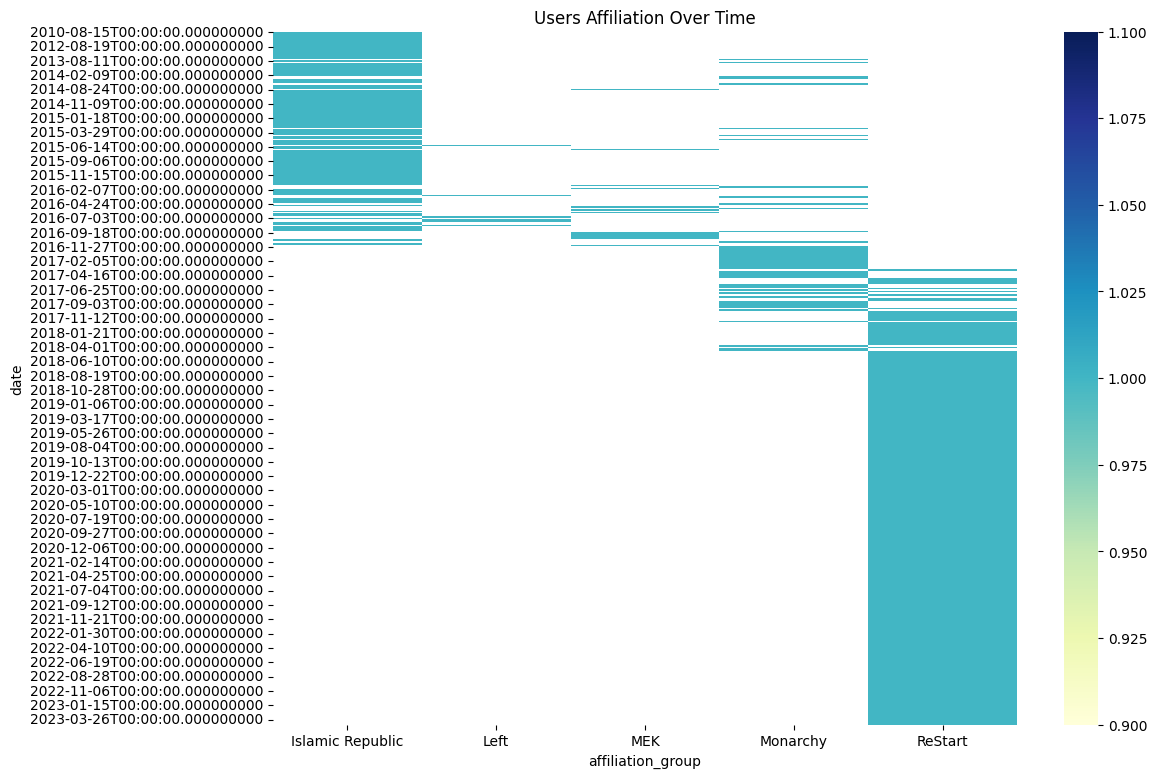

In [35]:
import seaborn as sns

grouped_data = user_affiliation_over_time.groupby(['date', 'affiliation_group']).size().reset_index(name='counts')

# Create a pivot table for the heatmap
pivot_table = grouped_data.pivot('date', 'affiliation_group', 'counts')

# Create the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title("Users Affiliation Over Time")
plt.show()


        date affiliation_group  counts
0 2010-08-15  Islamic Republic       1
1 2010-08-22  Islamic Republic       1
2 2010-08-29  Islamic Republic       1
3 2010-09-05  Islamic Republic       1
4 2011-05-01  Islamic Republic       1


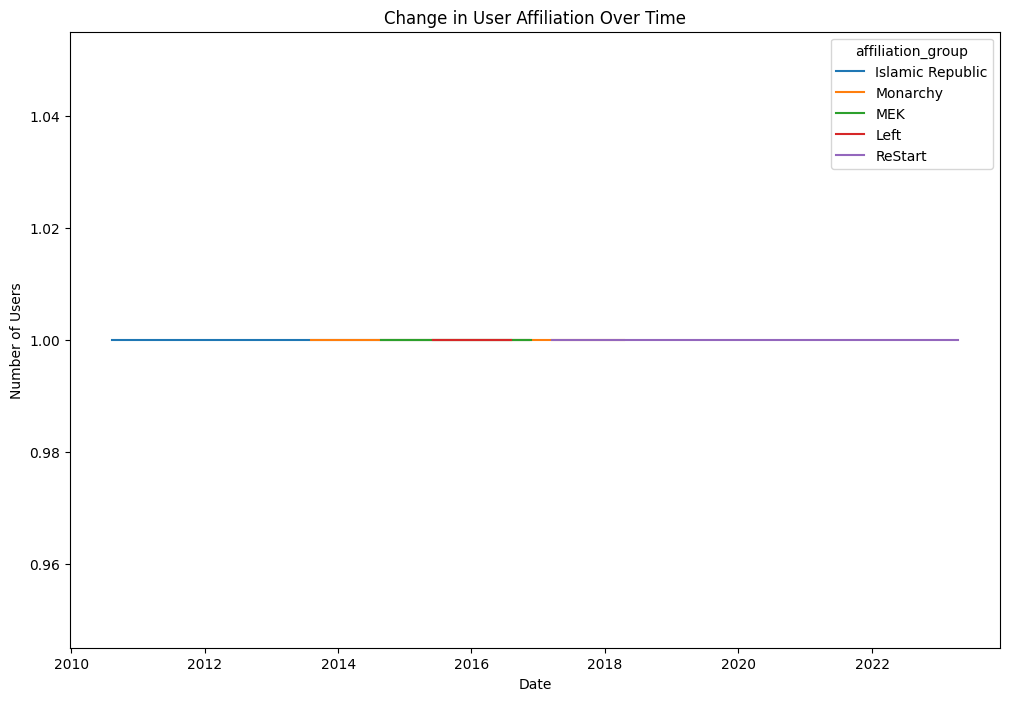

In [38]:
# Get the most common affiliation group for each user on each day
grouped_user_affiliation = user_affiliation_over_time.groupby(['userId', 'date']).agg(
    affiliation_group=('affiliation_group', lambda x: x.mode()[0])
)

# Reset the index
grouped_user_affiliation.reset_index(inplace=True)

# Group by 'date' and 'affiliation_group' and count unique 'userId'
grouped_data = grouped_user_affiliation.groupby(['date', 'affiliation_group'])['userId'].nunique().reset_index(name='counts')

# Print the first few rows of grouped_data
print(grouped_data.head())

# Create line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_data, x='date', y='counts', hue='affiliation_group')
plt.title("Change in User Affiliation Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.show()
